In [1]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib import colors
import json
from mne import read_epochs, pick_types
import os.path as op
from tools import *

from scipy.interpolate import UnivariateSpline, interp1d
from scipy.stats import norm

In [2]:
def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
            ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
            # ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
            ax.annotate(layer_labels[l_ix],[times[0]+0.01, th-0.01],size=15)
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()

In [3]:
js_inf = "/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/multilayer_11/info.json"
with open(js_inf) as pipeline_file:
    info = json.load(pipeline_file)

In [4]:
file_ix = 0

# specific info
crop_info = {
    "visual": (-0.2, 0.8),
    "motor": (-0.5, 0.5)
}
# computation
fif_MU = list(zip(info["sensor_epochs_paths"], info["MU_paths"]))
fif, MU = fif_MU[file_ix]
epo_type = [i for i in crop_info.keys() if i in fif][0]

fif = read_epochs(fif, verbose=False)
fif = fif.pick_types(meg=True, ref_meg=False, misc=False)
fif = fif.crop(tmin=crop_info[epo_type][0], tmax=crop_info[epo_type][1])
sfreq = fif.info["sfreq"]
fif_times = fif.times
fif = fif.get_data()
fif = np.mean(fif, axis=0)

new_mu_path = MU.split(".")[0] + ".npy"
if not op.exists(new_mu_path):
    MU = pd.read_csv(MU, sep="\t", header=None).to_numpy()
    np.save(new_mu_path, MU)
elif op.exists(new_mu_path):
    MU = np.load(new_mu_path)

MU = np.split(MU, info["n_surf"], axis=0)
flims = [0.1,125]

layer_shape = MU[0].shape[0]
cortical_thickness = np.load(info["cortical_thickness_path"])

Removing 5 compensators from info because not all compensation channels were picked.


In [5]:
vertex = 315
vertex_layers = np.array([mx[vertex] for mx in MU])
vertex_source = np.dot(fif.T, vertex_layers.T).T
vertex_layer_distance = cortical_thickness[vertex] / info["n_surf"]




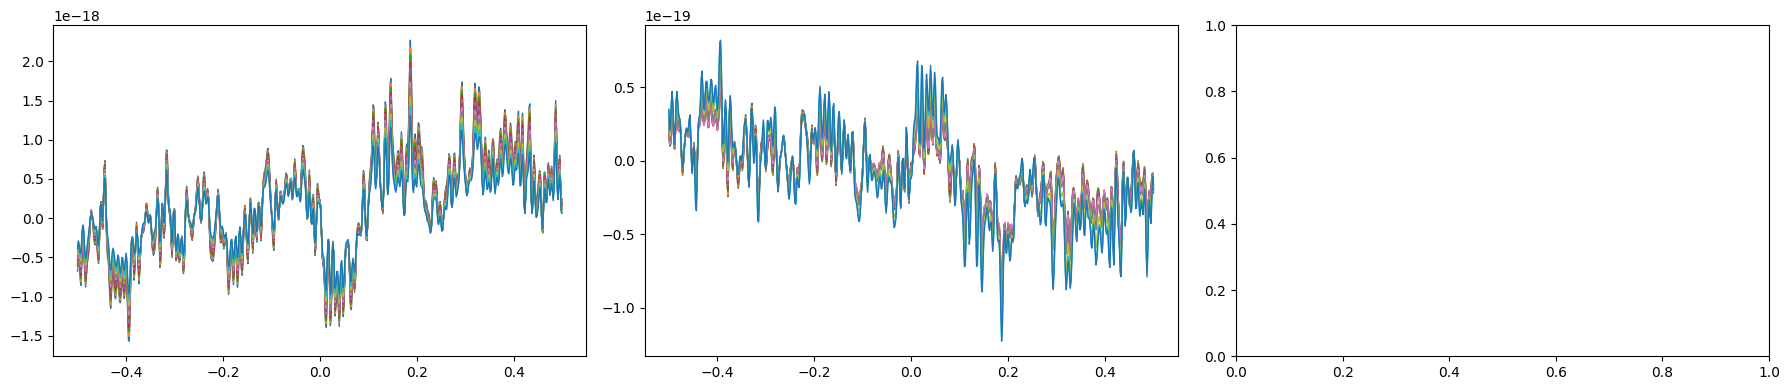

In [6]:
f, ax = plt.subplots(1,3, figsize=(18, 4))
ax[0].plot(fif_times,vertex_source.T, lw=1);
ax[1].plot(fif_times,np.gradient(vertex_source, axis=0).T, lw=1);
plt.tight_layout()

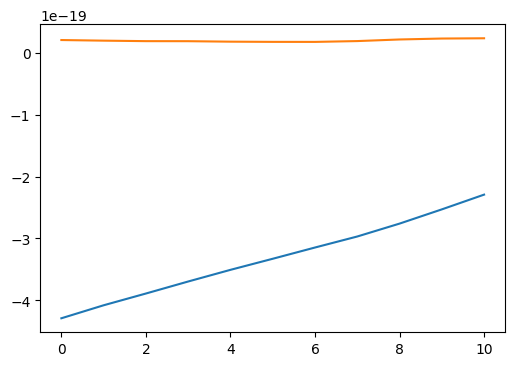

In [7]:
t = 8
f, ax = plt.subplots(1,1, figsize=(6, 4))
ax.plot(np.arange(11), vertex_source[:,t])
ax.plot(np.arange(11), np.gradient(vertex_source[:,t]))

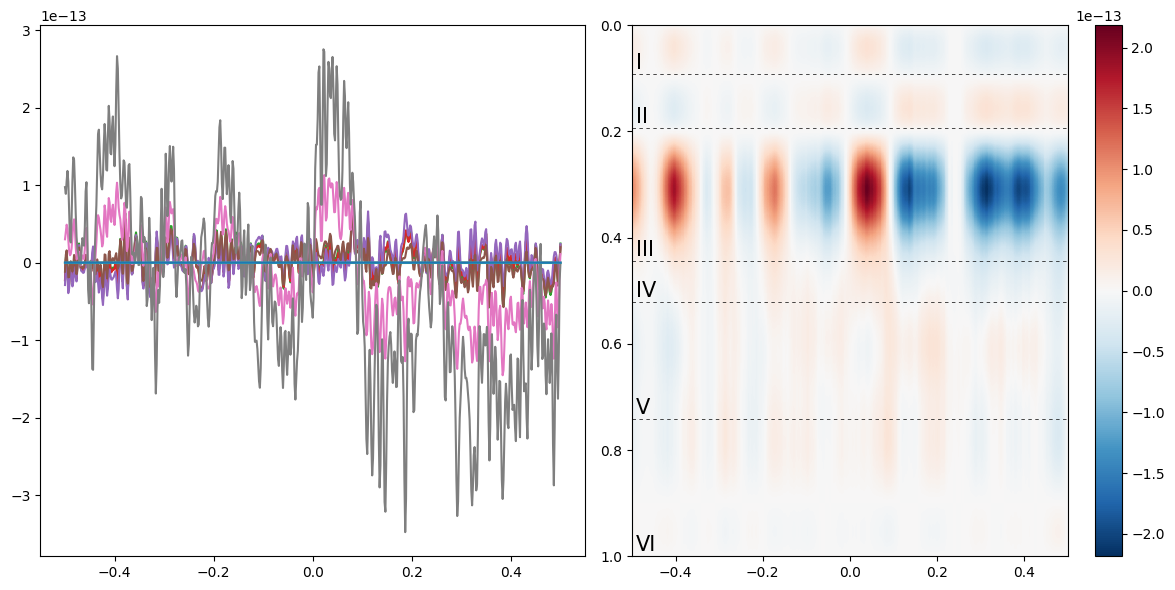

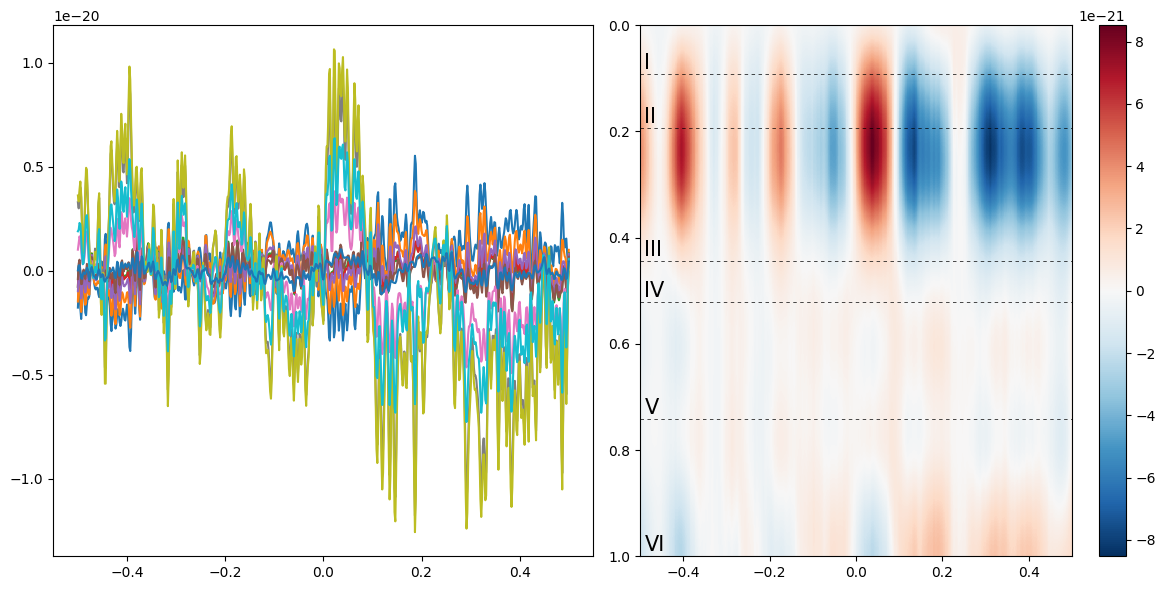

In [8]:
csd = compute_csd(
    vertex_source,fif_times, 
    vertex_layer_distance, 
    info["n_surf"]
)
f, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(fif_times,csd.T);
plot_csd(smooth_csd(csd, info["n_surf"]), [vertex],info["big_brain_layers_path"], fif_times, ax=ax[1], cmap="RdBu_r")
csd_g = np.gradient(np.gradient(vertex_source, axis=0), axis=0, edge_order=2)
f, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(fif_times,csd_g.T);
plot_csd(smooth_csd(csd_g, info["n_surf"]), [vertex],info["big_brain_layers_path"], fif_times, ax=ax[1], cmap="RdBu_r")

NameError: name 'smooth_AIC' is not defined

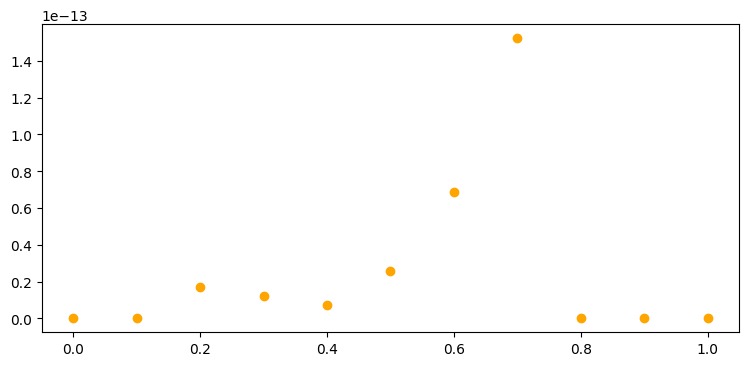

In [9]:
def smooth_vec(x, y, fs=None):
    if fs==None:
        s_factors = np.linspace(0,10, num=100)
        AIC_s = None
        AIC_best = np.inf

        for s in s_factors:
            uspline = UnivariateSpline(x, y, s=s)
            resid = y - uspline(x)
            logL = -np.sum(norm.logpdf(resid))
            AIC = 2 * len(uspline.get_knots()) - 2 * logL
            if AIC < AIC_best:
                AIC_best = AIC
                AIC_s = s
        uspline = UnivariateSpline(x, y, s=s)
        return(uspline, AIC_s, AIC_best)
    elif isinstance(fs, float) or isinstance(fs, int):
        uspline = UnivariateSpline(x, y, s=fs)
        return(uspline, None, None)
    else:
        raise AssertionError("Wrong parameters")
    
f, ax = plt.subplots(1, 1, figsize=(9, 4))
x = np.linspace(0, 1, num=11)
xs = np.linspace(0, 1, num=500)
ax.scatter(x, csd[:, 305], c="#FFA500", label="original data points")

f = interp1d(x, csd[:, 305], kind="quadratic")
ys_i = f(xs)

sp = smooth_AIC(x, csd[:, 305], fs=0)
ys = sp[0](xs)

sp_i = smooth_AIC(xs, ys)
ys_is = sp_i[0](xs)

ax.plot(xs, ys, label="cubic:zeroth");
ax.plot(xs, ys_i, label="interp quadratic");
ax.plot(xs, ys_is, label="cubic on interp");
ax.legend()

In [10]:
def aic_smooth_csd(csd, layers=11):
    layers, time = csd.shape
    smoothed = []
    x = np.linspace(0, 1, num=layers)
    xs = np.linspace(0, 1, num=500)
    for t in range(time):
        fx = interp1d(x, csd[:, t], kind="quadratic")
        ys = fx(xs)
        smoothed.append(ys)
    smoothed = np.array(smoothed).T
    return smoothed

In [11]:
aic_smooth_csd(csd)

array([[-6.73978244e-19, -4.18627931e-19, -4.78344464e-19, ...,
         4.91135920e-19,  1.63419072e-19,  2.44008905e-19],
       [ 3.07839784e-16, -8.49115607e-17, -1.75377684e-16, ...,
         3.21695273e-16, -4.17751503e-18, -3.39920676e-16],
       [ 6.03735422e-16, -1.65948741e-16, -3.43123668e-16, ...,
         6.29762218e-16, -8.34091300e-18, -6.66172714e-16],
       ...,
       [ 4.88416409e-16,  4.36743646e-16,  5.15654490e-16, ...,
        -5.66812567e-16, -1.13417832e-16, -1.22487147e-17],
       [ 2.49114689e-16,  2.22788983e-16,  2.63046655e-16, ...,
        -2.89156539e-16, -5.78562190e-17, -6.22239293e-18],
       [-3.91825048e-19, -2.89565033e-19, -3.33390841e-19, ...,
         3.39853164e-19,  7.47677952e-20,  6.09284941e-20]])

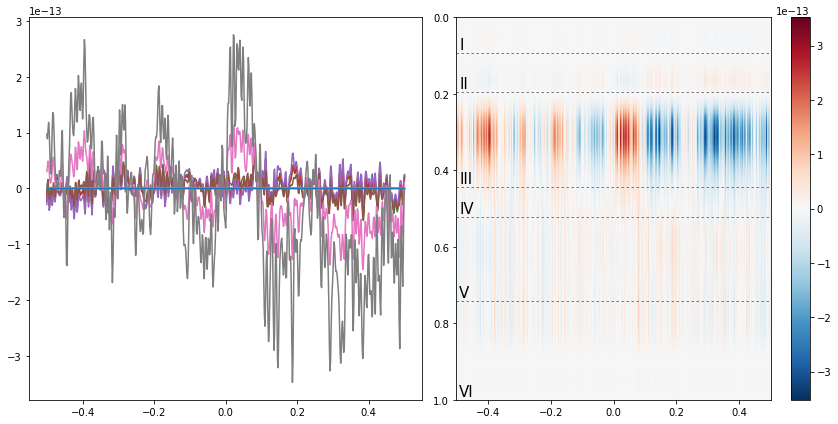

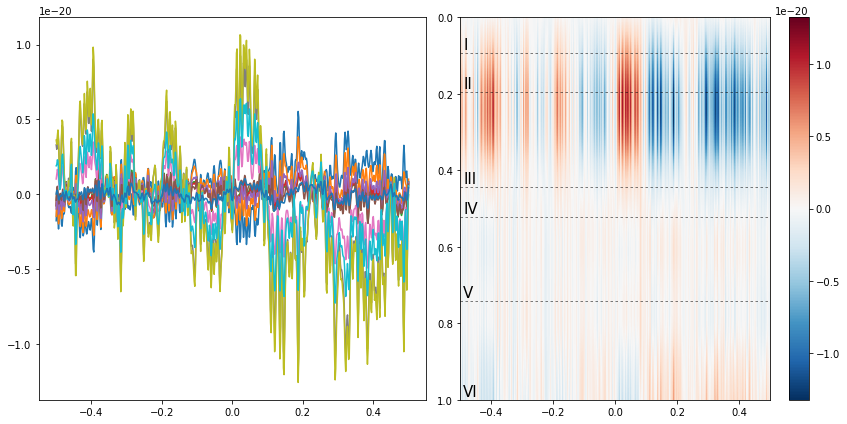

In [235]:
csd_g = np.gradient(np.gradient(vertex_source, axis=0), axis=0, edge_order=2)

f, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(fif_times,csd.T);
plot_csd(aic_smooth_csd(csd), [vertex],info["big_brain_layers_path"], fif_times, ax=ax[1], cmap="RdBu_r")


f, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(fif_times,csd_g.T);
plot_csd(aic_smooth_csd(csd_g), [vertex],info["big_brain_layers_path"], fif_times, ax=ax[1], cmap="RdBu_r")

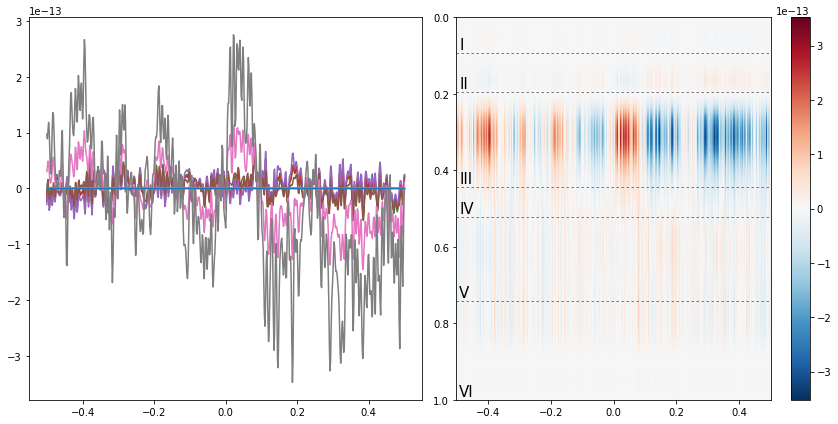

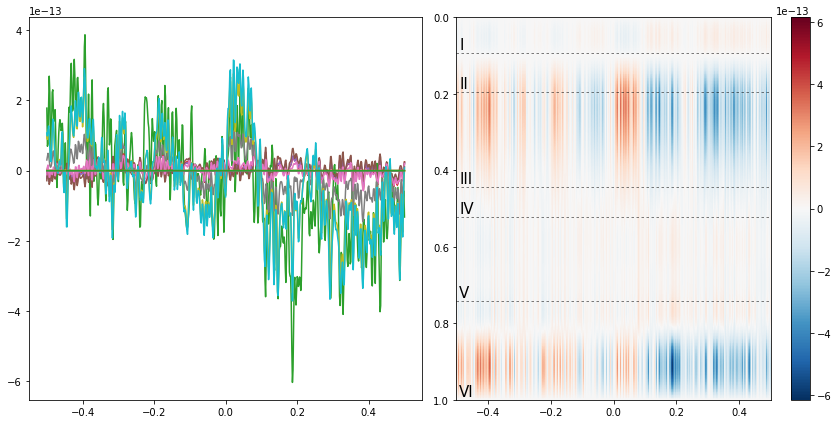

In [234]:
better_vs = np.vstack([vertex_source[0], vertex_source, vertex_source[-1]])

csds = compute_csd(
    better_vs,fif_times, 
    vertex_layer_distance, 
    info["n_surf"] + 2
)

f, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(fif_times,csd.T);
plot_csd(aic_smooth_csd(csd), [vertex],info["big_brain_layers_path"], fif_times, ax=ax[1], cmap="RdBu_r")

f, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(fif_times,csds.T);
plot_csd(aic_smooth_csd(csds[1:-1]), [vertex],info["big_brain_layers_path"], fif_times, ax=ax[1], cmap="RdBu_r")

In [233]:
better_vs[1:-1].shape

(11, 601)

In [1]:
import trimesh
import open3d as o3d
import open3d.visualization.rendering as rendering

ModuleNotFoundError: No module named 'open3d'